In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv


In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, Dense,Dropout,LSTM,Activation, RepeatVector, SimpleRNN
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [53]:
def read_data(data, index_col = 0):
    data = pd.read_csv(filepath)
    return data

filepath = "../input/hourly-energy-consumption/AEP_hourly.csv"
df = read_data(filepath, index_col=0)
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [54]:
# convert dates into datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head()

# df['hour'] = df['Datetime'].dt.year

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [55]:
# extract date related features

def data_conversion(data, index='none'):
    data = df.copy()
    
    data['year'] = data['Datetime'].dt.year
    data['month'] = data['Datetime'].dt.month
    data['day'] = data['Datetime'].dt.day
    data['week'] = data['Datetime'].dt.dayofweek
    data['yearday'] = data['Datetime'].dt.dayofyear
    return data


In [56]:
data = data_conversion(df)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 non-null  float64       
 2   year      121273 non-null  int64         
 3   month     121273 non-null  int64         
 4   day       121273 non-null  int64         
 5   week      121273 non-null  int64         
 6   yearday   121273 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 6.5 MB


# **Data preparation**

1.  For data preparation we have used AEP_hourly.csv and for testing we will use last year data and remainging data for training.
 

In [57]:
data.loc[data['year'] == 2018]
df[:107401]

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
107396,2017-12-31 19:00:00,19608.0
107397,2017-12-31 20:00:00,19442.0
107398,2017-12-31 21:00:00,19323.0
107399,2017-12-31 22:00:00,19092.0


In [58]:
# check for null values

df.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

In [59]:
# perform mean min-max normalization 

dataset = df.AEP_MW.values.reshape(-1,1)

sclar = MinMaxScaler(feature_range=(0,1))
dataset = sclar.fit_transform(dataset)
dataset.shape

(121273, 1)

In [60]:
def load_data(dataset, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(dataset)):
        X_train.append(dataset[i - seq_len: i, 0])
        y_train.append(dataset[i, 0])

    # last year i.e. 2018 data is used for testing
    X_test = X_train[107401:]
    y_test = y_train[107401:]

    # remaining data is used for training.
    X_train = X_train[:107401]
    y_train = y_train[:107401]

    # convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return [X_train, y_train, X_test, y_test]

In [61]:
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(dataset, seq_len)

X_train = X_train.reshape(X_train.shape[0], seq_len, 1)
X_test = X_test.reshape(X_test.shape[0], seq_len, 1)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((107401, 20, 1), (13852, 20, 1), (107401,), (13852,))

**Bidirectional LSTM model**

Below we have constructed a simple bidirectional LSTM model

In [62]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(40, return_sequences=True, input_shape=(X_train.shape[1],1))))
model.add(Bidirectional(LSTM(20,return_sequences= False, activation= 'linear')))
model.add(tf.keras.layers.Dropout(0.5))

model.add(Dense(1))
# model.add(layers.LSTM(256))

model.compile(loss='MSE', optimizer = 'adam')
hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3, batch_size=1000)
model.summary()

Train on 75180 samples, validate on 32221 samples
Epoch 1/10
75180/75180 [==============================] - 17s 233us/sample - loss: 0.0291 - val_loss: 0.0123
Epoch 2/10
75180/75180 [==============================] - 12s 158us/sample - loss: 0.0137 - val_loss: 0.0051
Epoch 3/10
75180/75180 [==============================] - 12s 163us/sample - loss: 0.0092 - val_loss: 0.0036
Epoch 4/10
75180/75180 [==============================] - 12s 158us/sample - loss: 0.0076 - val_loss: 0.0028
Epoch 5/10
75180/75180 [==============================] - 12s 158us/sample - loss: 0.0060 - val_loss: 0.0017
Epoch 6/10
75180/75180 [==============================] - 12s 158us/sample - loss: 0.0050 - val_loss: 0.0013
Epoch 7/10
75180/75180 [==============================] - 12s 159us/sample - loss: 0.0044 - val_loss: 0.0017
Epoch 8/10
75180/75180 [==============================] - 12s 162us/sample - loss: 0.0041 - val_loss: 0.0012
Epoch 9/10
75180/75180 [==============================] - 12s 159us/sample - l

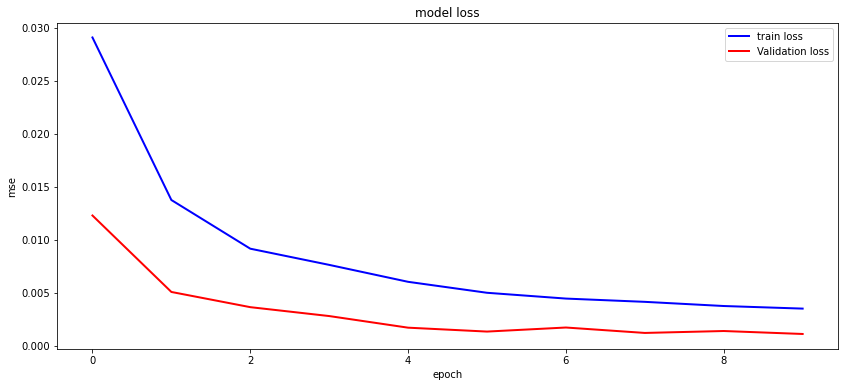

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(hist.history['loss'], 'b' ,label = 'train loss', linewidth=2)
ax.plot(hist.history['val_loss'], 'r', label ='Validation loss', linewidth=2)
ax.set_title('model loss')
ax.set_ylabel('mse')
ax.set_xlabel('epoch')
ax.legend()
plt.show()

In [64]:

pred = model.predict(X_test)

mse = mean_squared_error(y_test, pred)
print("mean sequare error = ",mse)

mean sequare error =  0.00095773581574227


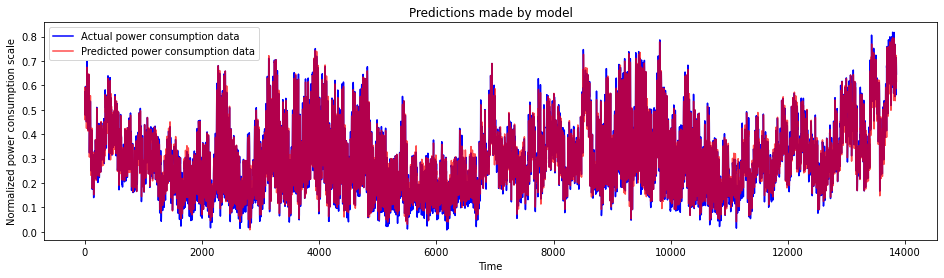

In [82]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
    plt.plot(test, color='blue', label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='red', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()


plot_predictions(y_test, pred, "Predictions made by model")

# **Data Preparation**

2. In second method we will categorize data based on seasons and predict energy consumption for a season which has height enegry consumption.

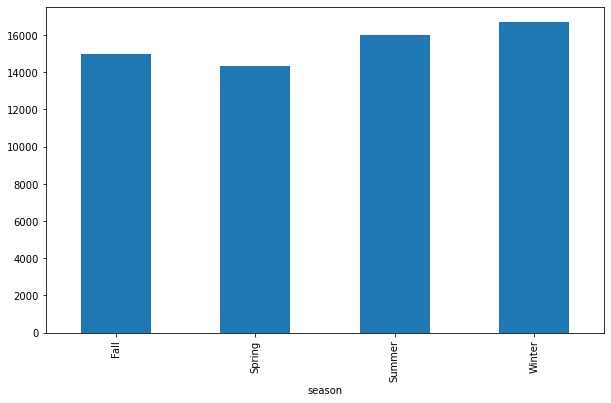

In [66]:
seasons = np.array(['Winter', 'Spring', 'Summer', 'Fall', 'Winter'])
f = np.searchsorted([80, 172, 264, 355], data.yearday)
data['season'] = seasons[f]

fig, ax = plt.subplots(figsize=(10,6))
data.groupby('season')['AEP_MW'].mean().plot.bar()

In [67]:
res = dict(tuple(data.groupby('season')))
res, res.keys()

({'Fall':                   Datetime   AEP_MW  year  month  day  week  yearday season
  264    2004-12-20 01:00:00  19050.0  2004     12   20     0      355   Fall
  265    2004-12-20 02:00:00  18940.0  2004     12   20     0      355   Fall
  266    2004-12-20 03:00:00  19015.0  2004     12   20     0      355   Fall
  267    2004-12-20 04:00:00  19178.0  2004     12   20     0      355   Fall
  268    2004-12-20 05:00:00  19494.0  2004     12   20     0      355   Fall
  ...                    ...      ...   ...    ...  ...   ...      ...    ...
  109799 2017-09-22 21:00:00  17657.0  2017      9   22     4      265   Fall
  109800 2017-09-22 22:00:00  16613.0  2017      9   22     4      265   Fall
  109801 2017-09-22 23:00:00  15347.0  2017      9   22     4      265   Fall
  109802 2017-09-23 00:00:00  14002.0  2017      9   23     5      266   Fall
  109826 2017-09-22 00:00:00  14636.0  2017      9   22     4      265   Fall
  
  [30327 rows x 8 columns],
  'Spring':              

In [68]:
fall_data = res['Fall']
spring_data = res['Spring']
summer_data = res['Summer']
winter_data = res['Winter']

**Based on above chart in winter, the energy consumption is highest**

Hence, for testing we will use winter data and for training we will use fall, spring and summer data.

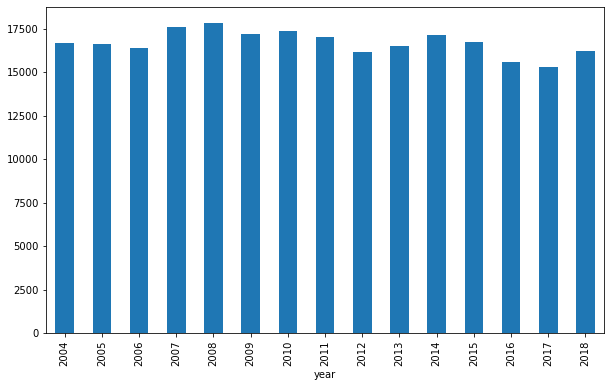

In [69]:
fig, ax = plt.subplots(figsize=(10,6))

winter_data.groupby('year')['AEP_MW'].mean().plot.bar()

In [70]:
concat_data = [fall_data, spring_data, summer_data]
for_train = pd.concat(concat_data)

In [71]:
for_train = for_train.drop('season',1)
for_train = for_train.reset_index()
for_train = for_train.drop('index',1)
for_train

,Datetime,AEP_MW,year,month,day,week,yearday
0,2004-12-20 01:00:00,19050.0,2004,12,20,0,355
1,2004-12-20 02:00:00,18940.0,2004,12,20,0,355
2,2004-12-20 03:00:00,19015.0,2004,12,20,0,355
3,2004-12-20 04:00:00,19178.0,2004,12,20,0,355
4,2004-12-20 05:00:00,19494.0,2004,12,20,0,355
...,...,...,...,...,...,...,...
90945,2018-06-22 21:00:00,15849.0,2018,6,22,4,173
90946,2018-06-22 22:00:00,15708.0,2018,6,22,4,173
90947,2018-06-22 23:00:00,14903.0,2018,6,22,4,173
90948,2018-06-23 00:00:00,13841.0,2018,6,23,5,174


In [72]:
for_test = winter_data.drop('season', 1)
for_test

,Datetime,AEP_MW,year,month,day,week,yearday
0,2004-12-31 01:00:00,13478.0,2004,12,31,4,366
1,2004-12-31 02:00:00,12865.0,2004,12,31,4,366
2,2004-12-31 03:00:00,12577.0,2004,12,31,4,366
3,2004-12-31 04:00:00,12517.0,2004,12,31,4,366
4,2004-12-31 05:00:00,12670.0,2004,12,31,4,366
...,...,...,...,...,...,...,...
121268,2018-01-01 20:00:00,21089.0,2018,1,1,0,1
121269,2018-01-01 21:00:00,20999.0,2018,1,1,0,1
121270,2018-01-01 22:00:00,20820.0,2018,1,1,0,1
121271,2018-01-01 23:00:00,20415.0,2018,1,1,0,1


In [73]:
dataset1 = for_train.AEP_MW.values.reshape(-1,1)

sclar = MinMaxScaler(feature_range=(0,1))
dataset1 = sclar.fit_transform(dataset1)

dataset11 = for_test.AEP_MW.values.reshape(-1,1)

sclar = MinMaxScaler(feature_range=(0,1))
dataset11 = sclar.fit_transform(dataset11)

dataset1.shape, dataset11.shape

((90950, 1), (30323, 1))

In [74]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, seq_len):
    dataX, dataY = [], []
    for i in range(seq_len, len(dataset)):
        appnd = dataset[i - seq_len: i, 0]
        dataX.append(appnd)
        dataY.append(dataset[i,0])
    return np.array(dataX), np.array(dataY)

In [75]:
seq_len = 20 #choose sequence length

trainX, trainY = create_dataset(dataset1, seq_len)
testX, testY = create_dataset(dataset11, seq_len)

In [76]:
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1],1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

trainX.shape, testX.shape

((90930, 20, 1), (30303, 20, 1))

# **Bidirectional LSTM**

In [77]:
model_s = tf.keras.Sequential()
model_s.add(tf.keras.layers.Bidirectional(LSTM(60, return_sequences=True, input_shape=(trainX.shape[1],1))))
model_s.add(Bidirectional(LSTM(20, return_sequences= False, activation= 'linear')))
model_s.add(tf.keras.layers.Dropout(0.5))
model_s.add(Dense(1))
# model.add(layers.LSTM(256))

model_s.compile(loss='MSE', optimizer = 'adam')
hist_s = model_s.fit(trainX, trainY, epochs=10, validation_split=0.3, batch_size=1000)
model_s.summary()

Train on 63650 samples, validate on 27280 samples
Epoch 1/10
63650/63650 [==============================] - 20s 310us/sample - loss: 0.0218 - val_loss: 0.0214
Epoch 2/10
63650/63650 [==============================] - 14s 223us/sample - loss: 0.0109 - val_loss: 0.0070
Epoch 3/10
63650/63650 [==============================] - 14s 220us/sample - loss: 0.0073 - val_loss: 0.0027
Epoch 4/10
63650/63650 [==============================] - 14s 222us/sample - loss: 0.0061 - val_loss: 0.0027
Epoch 5/10
63650/63650 [==============================] - 14s 220us/sample - loss: 0.0052 - val_loss: 0.0023
Epoch 6/10
63650/63650 [==============================] - 14s 227us/sample - loss: 0.0044 - val_loss: 0.0018
Epoch 7/10
63650/63650 [==============================] - 14s 223us/sample - loss: 0.0037 - val_loss: 0.0014
Epoch 8/10
63650/63650 [==============================] - 14s 222us/sample - loss: 0.0033 - val_loss: 0.0012
Epoch 9/10
63650/63650 [==============================] - 14s 222us/sample - l

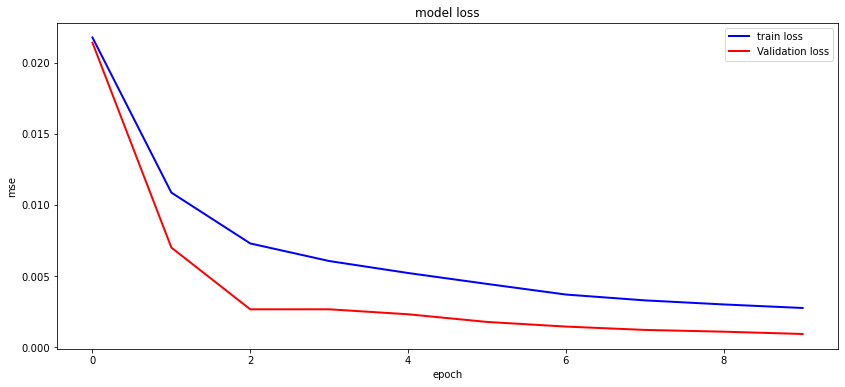

In [78]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(hist_s.history['loss'], 'b' ,label = 'train loss', linewidth=2)
ax.plot(hist_s.history['val_loss'], 'r', label ='Validation loss', linewidth=2)
ax.set_title('model loss')
ax.set_ylabel('mse')
ax.set_xlabel('epoch')
ax.legend()
plt.show()

In [79]:
# compute mean sequare error
predictions = model_s.predict(testX)

mse = mean_squared_error(testY, predictions)
print("mean square error = ", mse)

mean square error =  0.0017286553510718072


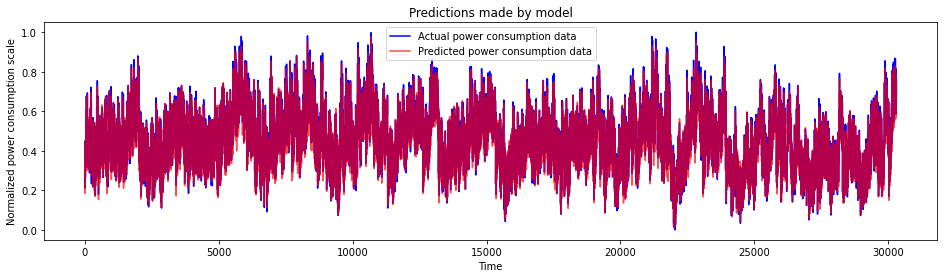

In [81]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
    plt.plot(test, color='blue', label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='red', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()


plot_predictions(testY, predictions, "Predictions made by model")
